In [4]:
from dask_jobqueue import PBSCluster

cluster = PBSCluster(#processes=5, threads=4, memory="12GB",
                     processes=1, threads=10, memory="54GB",
                     interface="ib0",
                     group_list='g26209',
                     resource_spec='select=1:ncpus=20:mpiprocs=5:model=ivy',
                     walltime='06:00:00')
cluster.start_workers(8)
cluster

/nobackup/rpaberna/conda/envs/pangeo/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


VBox(children=(HTML(value='<h2>PBSCluster</h2>'), HBox(children=(HTML(value='\n<div>\n  <style scoped>\n    .dataframe tbody tr th:only-of-type {\n        vertical-align: middle;\n    }\n\n    .dataframe tbody tr th {\n        vertical-align: top;\n    }\n\n    .dataframe thead th {\n        text-align: right;\n    }\n  </style>\n  <table style="text-align: right;">\n    <tr><th>Workers</th> <td>0</td></tr>\n    <tr><th>Cores</th> <td>0</td></tr>\n    <tr><th>Memory</th> <td>0 B</td></tr>\n  </table>\n</div>\n', layout=Layout(min_width='150px')), Accordion(children=(HBox(children=(IntText(value=0, description='Workers', layout=Layout(width='150px')), Button(description='Scale', layout=Layout(width='150px'), style=ButtonStyle()))), HBox(children=(IntText(value=0, description='Minimum', layout=Layout(width='150px')), IntText(value=0, description='Maximum', layout=Layout(width='150px')), Button(description='Adapt', layout=Layout(width='150px'), style=ButtonStyle())))), layout=Layout(min_width='500px'), selected_index=None, _titles={'0': 'Manual Scaling', '1': 'Adaptive Scaling'}))), HTML(value='<p><b>Dashboard: </b><a href="http://10.150.15.193:8787/status" target="_blank">http://10.150.15.193:8787/status</a></p>\n')))

In [2]:
18*3

54

In [5]:
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://10.150.15.193:43308 Dashboard: http://10.150.15.193:8787/status,Cluster Workers: 8 Cores: 80 Memory: 432.00 GB


In [51]:
client.restart()

Client Scheduler: tcp://10.150.15.193:35103 Dashboard: http://10.150.15.193:8787/status,Cluster Workers: 25 Cores: 100 Memory: 334.94 GB


In [6]:
from xmitgcm import open_mdsdataset
import subprocess
import os
import numpy as np
import dask.array as dsa
import dask
import xarray as xr

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

In [8]:
def unlimit_memory():
    import resource
    print(resource.getrlimit(resource.RLIMIT_AS))
    resource.setrlimit(resource.RLIMIT_AS, (resource.RLIM_INFINITY, resource.RLIM_INFINITY))
    print(resource.getrlimit(resource.RLIMIT_AS))
unlimit_memory()

(-1, -1)
(-1, -1)


In [9]:
client.run(unlimit_memory)

{'tcp://10.150.8.197:35761': None,
 'tcp://10.150.8.198:35185': None,
 'tcp://10.150.8.199:43573': None,
 'tcp://10.150.8.200:40460': None,
 'tcp://10.150.8.203:39382': None,
 'tcp://10.150.8.204:38949': None,
 'tcp://10.150.8.209:34551': None,
 'tcp://10.150.8.211:41361': None}

In [7]:
import dask.array as dsa
zeros = dsa.zeros((1000000, 10000), chunks=(2000, 2000))
zeros.sum().compute()

0.0

In [10]:
# necessary on ldan
prefix = '/pleiades'

data_dir = prefix + '/u/dmenemen/llc_4320/MITgcm/run/'
grid_dir = prefix + '/u/dmenemen/llc_4320/grid/'

dtype = np.dtype('>f4')

# can complete 300 files in < 12 hours
nfiles = 300

# the first available iteration is iter0=10368

delta_t = 25. # seconds
all_iters = np.arange(10368, 1310544+1, 144)
time = delta_t * all_iters
    
ds = open_mdsdataset(data_dir, grid_dir=grid_dir,
                     iters=list(all_iters)[:1], geometry='llc', read_grid=True,
                     default_dtype=np.dtype('>f4'), delta_t=delta_t,
                     ignore_unknown_vars=True)

# fix time
del ds['iter']
ds['time'] = xr.Variable(('time',), time, ds.time.attrs)
ds.time.attrs['units'] = 'seconds since 2011-09-10'
ds.coords['iter'] = xr.Variable(('time',), all_iters)
ds

/home6/rpaberna/xmitgcm/xmitgcm/mds_store.py:721: UserWarning: Couldn't find available_diagnostics.log in /pleiades/u/dmenemen/llc_4320/MITgcm/run/. Using default version.
  "in %s. Using default version." % data_dir)
/home6/rpaberna/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home6/rpaberna/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 9030)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 2.736e+05 ...
    XC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 432

In [11]:
ds_2d = ds.isel(k=1, k_l=1, k_u=1, k_p1=slice(0,2))
ds_2d

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k_p1: 2, time: 9030)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    k        int64 1
    k_u      int64 1
    k_l      int64 1
  * k_p1     (k_p1) int64 0 1
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 2.736e+05 ...
    XC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    XG       (face, j_g, i_g) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YG       (face, j_g, i_g) >f4 dask.array<shape=(13, 432

In [12]:
nz, nface, ny, nx = ds.hFacC.shape

In [13]:
index_fname = 'llc4320_compressed_level_index.nc'

try:
    ds_index = xr.open_dataset(index_fname)
except OSError:
    # compute and save mask indices
    ds_index = ((ds.reset_coords()[['hFacC', 'hFacW','hFacS']] > 0)
       .sum(axis=(1, 2, 3)))
    ds_index.coords['k'] = ds.k
    ds_index.load().to_netcdf(index_fname)
ds_index

<xarray.Dataset>
Dimensions:  (k: 90)
Coordinates:
    Z        (k) float32 ...
    drF      (k) float32 ...
    PHrefC   (k) float32 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Data variables:
    hFacC    (k) int64 ...
    hFacW    (k) int64 ...
    hFacS    (k) int64 ...

In [14]:
import xmitgcm.utils as xgu

In [15]:
#ddir = prefix + '/u/dmenemen/llc_4320/compressed'
ddir = '/nobackupp1/dmenemen/llc_4320/compressed'

def load_level_from_3D_field(varname, inum, offset, count, mask, dtype):
    inum_str = '%010d' % inum
    fname = os.path.join(ddir, inum_str,
                         '%s.%s.data.shrunk' % (varname, inum_str))
    
    with open(fname, mode='rb') as file:
        file.seek(offset * dtype.itemsize)
        data = np.fromfile(file, dtype=dtype, count=count)
    
    
    data_blank = np.full_like(mask, np.nan, dtype='f4')
    data_blank[mask] = data
    data_blank.shape = mask.shape
    data_llc = xgu._reshape_llc_data(data_blank, jdim=0).compute(get=dask.get)
    data_llc.shape = (1,) + data_llc.shape
    return data_llc

def lazily_load_level_from_3D_field(varname, inum, offset, count, mask, dtype):
    return dsa.from_delayed(dask.delayed(load_level_from_3D_field)
                            (varname, inum, offset, count, mask, dtype),
                            (1, nface, ny, nx), dtype)


def make_data_variable(varname, all_iters, k=0, point='C'):
    shape = (1, nface, ny, nz)
    dtype = np.dtype('>f4')
    strides = [0,] + list(ds_index['hFac' + point].data)
    offset = strides[k]
    count = strides[k+1]
    
    # load mask from raw data
    hfac = xgu.read_mds(grid_dir + 'hFac' + point,
                        use_mmap=True, dask_delayed=False, force_dict=False)
    mask = hfac[k]>0
    mask_future = client.scatter(mask)
    
    data = dsa.concatenate([lazily_load_level_from_3D_field
                            (varname, i, offset, count, mask_future, dtype)
                            for i in all_iters], axis=0)
    
    return data

In [16]:
var_info = [('SSS', 'Salt', ['j', 'i']),
            ('SST', 'Theta', ['j', 'i']),
            ('Eta', 'Eta', ['j', 'i']),
            ('U', 'U', ['j', 'i_g']),
            ('V', 'V', ['j_g', 'i'])]

In [17]:
#varname, origname = 'SSS', 'Salt'
#varname, origname = 'SST', 'Theta'

ds_subset = ds_2d.copy()
for varname, origname, dims2d in var_info:
    ds_subset[varname] = xr.Variable(['time', 'face'] + dims2d,
                                   make_data_variable(origname, ds_subset.iter))
ds_subset

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k_p1: 2, time: 9030)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    k        int64 1
    k_u      int64 1
    k_l      int64 1
  * k_p1     (k_p1) int64 0 1
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 2.736e+05 ...
    XC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    XG       (face, j_g, i_g) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YG       (face, j_g, i_g) >f4 dask.array<shape=(13, 432

In [18]:
ds_subset.nbytes / 1e9

43831.110119708

In [19]:
# set up encodings
import zarr
# doesn't work: AttributeError: module 'zarr' has no attribute 'Blosc'
compressor = zarr.Blosc(cname='zstd', clevel=3, shuffle=2)

In [20]:
for varname in ds_2d.variables:
    shape = ds_2d[varname].shape
    ds_2d[varname].encoding = {'compressor': compressor}
    print(varname, ds_2d[varname].encoding)

i {'compressor': Blosc(cname='zstd', clevel=3, shuffle=BITSHUFFLE, blocksize=0)}
i_g {'compressor': Blosc(cname='zstd', clevel=3, shuffle=BITSHUFFLE, blocksize=0)}
j {'compressor': Blosc(cname='zstd', clevel=3, shuffle=BITSHUFFLE, blocksize=0)}
j_g {'compressor': Blosc(cname='zstd', clevel=3, shuffle=BITSHUFFLE, blocksize=0)}
k {'compressor': Blosc(cname='zstd', clevel=3, shuffle=BITSHUFFLE, blocksize=0)}
k_u {'compressor': Blosc(cname='zstd', clevel=3, shuffle=BITSHUFFLE, blocksize=0)}
k_l {'compressor': Blosc(cname='zstd', clevel=3, shuffle=BITSHUFFLE, blocksize=0)}
k_p1 {'compressor': Blosc(cname='zstd', clevel=3, shuffle=BITSHUFFLE, blocksize=0)}
face {'compressor': Blosc(cname='zstd', clevel=3, shuffle=BITSHUFFLE, blocksize=0)}
time {'compressor': Blosc(cname='zstd', clevel=3, shuffle=BITSHUFFLE, blocksize=0)}
XC {'compressor': Blosc(cname='zstd', clevel=3, shuffle=BITSHUFFLE, blocksize=0)}
YC {'compressor': Blosc(cname='zstd', clevel=3, shuffle=BITSHUFFLE, blocksize=0)}
XG {'comp

In [21]:
for varname in ds_subset.data_vars:
    shape = ds_subset[varname].shape
    ds_subset[varname].encoding = {'chunks': (1, 1, nx, nx),
                                   'compressor': compressor}
    print(ds_subset[varname].encoding)

{'chunks': (1, 1, 4320, 4320), 'compressor': Blosc(cname='zstd', clevel=3, shuffle=BITSHUFFLE, blocksize=0)}
{'chunks': (1, 1, 4320, 4320), 'compressor': Blosc(cname='zstd', clevel=3, shuffle=BITSHUFFLE, blocksize=0)}
{'chunks': (1, 1, 4320, 4320), 'compressor': Blosc(cname='zstd', clevel=3, shuffle=BITSHUFFLE, blocksize=0)}
{'chunks': (1, 1, 4320, 4320), 'compressor': Blosc(cname='zstd', clevel=3, shuffle=BITSHUFFLE, blocksize=0)}
{'chunks': (1, 1, 4320, 4320), 'compressor': Blosc(cname='zstd', clevel=3, shuffle=BITSHUFFLE, blocksize=0)}


In [23]:
base_dir = '/nobackup/rpaberna/llc4320_zarr/'

In [19]:
#ds_2d.to_zarr(base_dir + 'grid')

In [59]:
# !mkdir llc4320_checksums

In [ ]:
for vname in ['V']:
    output_dir = base_dir + vname
    ds_drop = ds_subset[[vname]].reset_coords(drop=True)
    to_zarr = ds_drop.to_zarr(output_dir, compute=False)
    ts = ds_drop[vname].mean(axis=(-1, -2))
    res, ts = dask.compute(to_zarr, ts, retries=5)
    ts.to_netcdf('llc4320_checksums/%s_ts.nc' % vname)
    plt.figure()
    ts.fillna(-99).plot.line(x='time', figsize=(16,5))

/nobackup/rpaberna/conda/envs/pangeo/lib/python3.6/site-packages/distributed/worker.py:820: UserWarning: Large object of size 15.58 MB detected in task graph: 
  ('store-e4a285fe-7ae4-11e8-9af5-002590dd4024', <xa ... x2abf68a7c438>)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


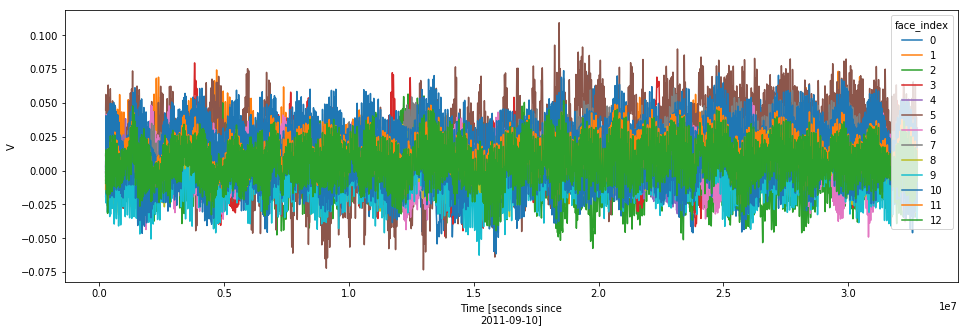

In [26]:
ts.fillna(-99).plot.line(x='time', figsize=(16,5))

In [22]:
output_dir = '/nobackup/rpaberna/llc4320_zarr/' + 'eta_u_v'
%time to_store = ds_subset.to_zarr(output_dir, compute=False)

CPU times: user 6.11 s, sys: 373 ms, total: 6.48 s
Wall time: 8.5 s


In [23]:
%time store_persist = to_store.persist(retries=5)

CPU times: user 1min 50s, sys: 1.38 s, total: 1min 51s
Wall time: 1min 51s


/nobackup/rpaberna/conda/envs/pangeo/lib/python3.6/site-packages/distributed/worker.py:820: UserWarning: Large object of size 62.47 MB detected in task graph: 
  ('store-1496386c-7a15-11e8-8d4d-002590a22f16', <xa ... x2abf5ffda828>)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


In [ ]:
store_persist.compute()

Delayed('_finalize_store-0c87b1ef-a735-494d-9cb8-c39f7a4aa2e1')

In [27]:
ds_zarr = xr.open_zarr('/nobackup/rpaberna/llc4320_zarr/U')
ds_zarr

<xarray.Dataset>
Dimensions:  (face: 13, i_g: 4320, j: 4320, time: 9030)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * time     (time) datetime64[ns] 2011-09-13 2011-09-13T01:00:00 ...
Data variables:
    U        (time, face, j, i_g) float32 dask.array<shape=(9030, 13, 4320, 4320), chunksize=(1, 1, 4320, 4320)>
Attributes:
    Conventions:  CF-1.6
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...
    source:       MITgcm
    title:        netCDF wrapper of MITgcm MDS binary data

In [28]:
ts_u = ds_zarr.U.mean(axis=(-1, -2)).load(retries=4)

/nobackup/rpaberna/conda/envs/pangeo/lib/python3.6/site-packages/bokeh/core/json_encoder.py:80: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(type(obj), np.float):


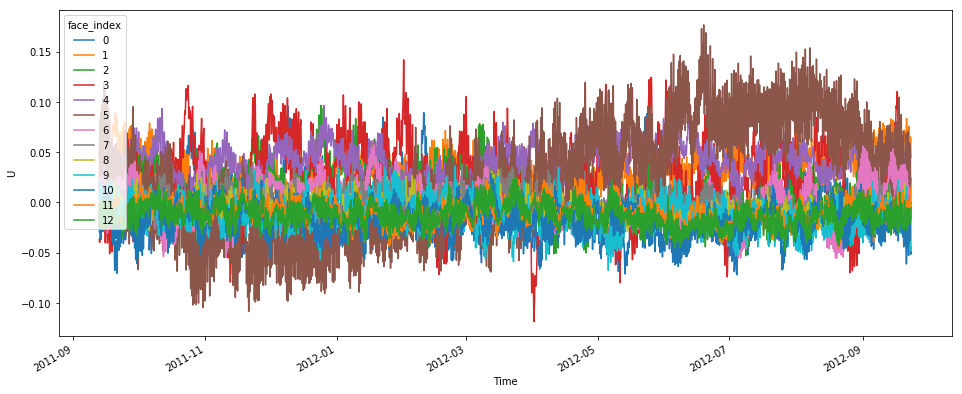

In [29]:
ts_u.fillna(-99).plot.line(x='time', figsize=(16,6))

In [30]:
ls llc4320_checksums/

V_.nc


In [31]:
ts_u.to_netcdf('llc4320_checksums/U_ts.nc')

/nobackup/rpaberna/conda/envs/pangeo/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


In [21]:
client.restart()

distributed.client - ERROR - Restart timed out after 6.000000 seconds


Client Scheduler: tcp://10.150.8.140:44264 Dashboard: http://10.150.8.140:8787/status,Cluster Workers: 25 Cores: 100 Memory: 334.94 GB


distributed.scheduler - ERROR - Not all workers responded positively: ['timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out']
NoneType: None


In [ ]:
ts_eta = ds_subset.Eta.mean(dim=('j', 'i')).load(retries=4)

In [39]:
%time sss_ts = ds_subset.SSS.mean(dim=('face', 'j', 'i')).load()

CPU times: user 5min 51s, sys: 27.9 s, total: 6min 19s
Wall time: 13min 9s


In [39]:
client.restart()

Client Scheduler: tcp://10.150.8.140:33770 Dashboard: http://10.150.8.140:8787/status,Cluster Workers: 25 Cores: 100 Memory: 334.94 GB


In [32]:
# with zstd compressor
zs = zarr.open_group(output_dir)
zs[varname].info

Name,/SSS
Type,zarr.core.Array
Data type,>f4
Shape,"(1000, 13, 4320, 4320)"
Chunk shape,"(1, 1, 4320, 4320)"
Order,C
Read-only,False
Compressor,"Blosc(cname='zstd', clevel=3, shuffle=BITSHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,970444800000 (903.8G)
No. bytes stored,280606654962 (261.3G)


In [28]:
# with default compressor
zs = zarr.open_group(output_dir)
zs[varname].info

Name,/SSS
Type,zarr.core.Array
Data type,>f4
Shape,"(1000, 13, 4320, 4320)"
Chunk shape,"(1, 1, 4320, 4320)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,970444800000 (903.8G)
No. bytes stored,306000028887 (285.0G)


In [33]:
%time ds_subset.SSS.mean().load()

CPU times: user 5.08 s, sys: 468 µs, total: 5.08 s
Wall time: 1min 33s


<xarray.DataArray 'SSS' ()>
array(33.802746, dtype=float32)

In [26]:
ds_zarr = xr.open_zarr(output_dir)
ds_zarr

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 9030)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * time     (time) datetime64[ns] 2011-09-13 2011-09-13T01:00:00 ...
Data variables:
    SST      (time, face, j, i) float32 dask.array<shape=(9030, 13, 4320, 4320), c

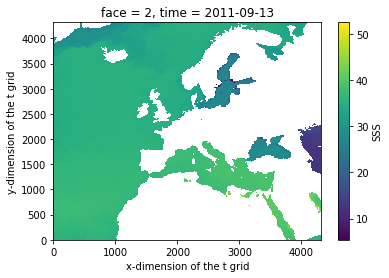

In [27]:
ds_zarr.SSS[0,2].plot()

In [29]:
ds_zarr.SSS.nbytes / 1e9

8763.116544

In [28]:
%time ds_zarr.SSS.mean().load()

/nobackup/rpaberna/conda/envs/pangeo/lib/python3.6/site-packages/bokeh/core/json_encoder.py:80: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(type(obj), np.float):


CPU times: user 11min 28s, sys: 30.6 s, total: 11min 59s
Wall time: 12min 26s


<xarray.DataArray 'SSS' ()>
array(33.887695, dtype=float32)

In [48]:
sss_ts.load()

<xarray.DataArray 'SSS' (time: 1000)>
array([33.754883, 33.75502 , 33.755108, ..., 33.857735, 33.857876, 33.85795 ],
      dtype=float32)
Coordinates:
  * time     (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 2.736e+05 ...

In [22]:
del sss_ts

In [13]:
sss_ts = ds_subset.SSS.mean(dim=('face', 'j', 'i')).load()

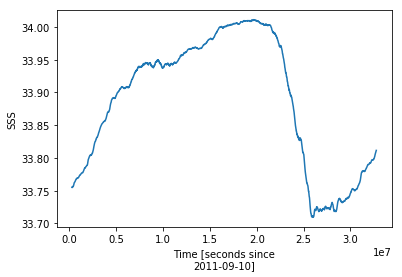

In [45]:
sss_ts.plot()

In [19]:
del sss_ts

In [13]:
import gcsfs
fs = gcsfs.GCSFileSystem(project='pangeo-181919', token='/pleiades/u/rpaberna/pangeo-ace7f297876d.json')
fs.buckets

['pangeo', 'pangeo-data', 'pangeo-data-private', 'zarr_store_test']

In [21]:
gcsmap = gcsfs.mapping.GCSMap('pangeo-data/llc4320/sss_subset_test', gcs=fs, check=True, create=True)

In [ ]:
ds_subset.to_zarr(store=gcsmap)

In [52]:
from xmitgcm.default_diagnostics import diagnostics
from io import StringIO
diag_file = StringIO(diagnostics)
available_diags = xgu.parse_available_diagnostics(diag_file)

/home6/rpaberna/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)


In [53]:
available_diags['oceQnet']

{'attrs': {'long_name': 'net surface heat flux into the ocean (+=down), >0 increases theta',
  'standard_name': 'oceQnet',
  'units': 'W/m^2'},
 'dims': ['j', 'i']}

In [131]:
salt = make_data_variable('Salt', ds.iter[:100])
salt

dask.array<concatenate, shape=(100, 13, 4320, 4320), dtype=float32, chunksize=(1, 13, 4320, 4320)>

In [119]:
%time salt = load_level_from_3D_field('Salt', ds.iter[20], offset, count, mask, dtype)

CPU times: user 2.13 s, sys: 1.39 s, total: 3.52 s
Wall time: 3.51 s


In [120]:
salt.shape

(1, 13, 4320, 4320)

In [104]:
mask_future = client.scatter(mask)
mask_future

<Future: status: finished, type: ndarray, key: ndarray-48afdcbaadaac3db5b6647ee7e4cfd20>

In [105]:
salt_laz = lazily_load_level_from_3D_field('Salt', ds.iter[20], offset, count, mask_future, dtype)

In [127]:
salt = dsa.concatenate([lazily_load_level_from_3D_field('Salt', i, offset, count, mask_future, dtype)
                        for i in ds.iter.data[:2000]], axis=0)
salt

dask.array<concatenate, shape=(2000, 13, 4320, 4320), dtype=float32, chunksize=(1, 13, 4320, 4320)>

In [128]:
%time salt.mean().compute()

CPU times: user 8.09 s, sys: 251 ms, total: 8.34 s
Wall time: 5min 35s


nan

In [129]:
salt.nbytes / 1e9

1940.8896

In [106]:
%time salt_laz.compute()

CPU times: user 1.16 s, sys: 1.26 s, total: 2.42 s
Wall time: 30.6 s


array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [34.086628, 34.086376, 34.084053, ..., 33.690487, 33.691048,
         33.69217 ],
        [34.085068, 34.086613, 34.086563, ..., 33.69163 , 33.690163,
         33.68965 ],
        [34.08223 , 34.084858, 34.0863  , ..., 33.69662 , 33.694263,
         33.69248 ]],

       [[34.078377, 34.081936, 34.084553, ..., 33.701744, 33.700275,
         33.698723],
        [34.073643, 34.07795 , 34.081623, ..., 33.70896 , 33.707603,
         33.705936],
        [34.068047, 34.07334 , 34.07768 , ..., 33.723045, 33.721172,
         33.718613],
        ...,
        [35.67249 , 35.669434, 35.658234, ..., 35.5209  , 35.54748 ,
         35.595264],
        [35.67501 , 35.67225 , 35.66227 , ..., 35.498997, 35.50806 ,
   

In [82]:
%time salt_reshape = xgu._reshape_llc_data(salt, jdim=0).compute(get=dask.get)

CPU times: user 2 s, sys: 452 ms, total: 2.46 s
Wall time: 5.87 s


In [25]:
with open(fname, mode='rb') as file:
    file.seek(offset * dtype.itemsize)
    data = np.fromfile(file, dtype=dtype, count=count)

In [26]:
data.shape

(140637966,)

In [65]:
# need to use the raw data for the mask
hFacC = xgu.read_mds(grid_dir + 'hFacC', use_mmap=True, dask_delayed=False, force_dict=False)
hFacC.shape

(90, 56160, 4320)

In [74]:
%time mask_lev0 = hFacC[k]>0

CPU times: user 238 ms, sys: 137 ms, total: 375 ms
Wall time: 373 ms


In [66]:
mask_lev0 = hFacC[k]>0
data_blank = np.full_like(mask_lev0, np.nan, dtype='>f4')

In [76]:
inum

10800

In [30]:
mask_lev0.sum()

140637966

In [67]:
data_blank[mask_lev0] = data

In [33]:
data_blank.shape = mask_lev0.shape
data_blank.shape

(13, 4320, 4320)

In [68]:
data_blank.shape = (13*4320, 4320)

In [69]:
data_reshaped = xgu._reshape_llc_data(data_blank, jdim=0)

In [70]:
da_rs_c = data_reshaped.compute(get=dask.get)

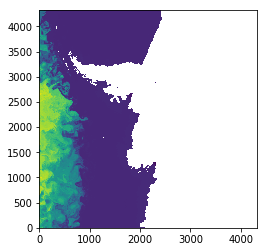

In [71]:
plt.imshow(da_rs_c[-1], origin='bottom')

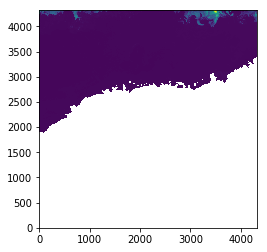

In [72]:
plt.imshow(da_rs_c[0], origin='bottom')

In [13]:
for k in range(nz):
    indices0 = dsa.flatnonzero(maskc.data[0]).compute()

NameError: name 'nz' is not defined

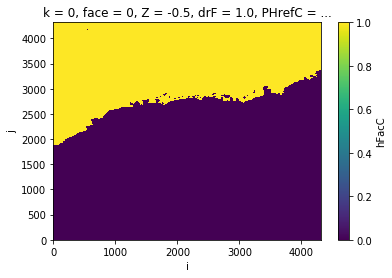

In [73]:
ds.hFacC[0,0].plot()

In [69]:
len(indices0)

101973234

In [62]:
def get_k_strides(mask):
    # mask is true where we keep the data
    k_masked = ds.k.where(mask).data.ravel()
    

<xarray.DataArray (k: 90, face: 13, j: 4320, i: 4320)>
dask.array<shape=(90, 13, 4320, 4320), dtype=float64, chunksize=(1, 1, 4320, 4320)>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    Z        (k) float32 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
    drF      (k) float32 1.0 1.14 1.3 1.49 1.7 1.93 2.2 2.5 2.84 3.21 3.63 ...
    PHrefC   (k) float32 4.905 15.4017 27.3699 41.05485 56.7018 74.50695 ...
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    rA       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    Depth    (face, j, i) >f4 dask.array<s

In [46]:
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 9030)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 2.736e+05 ...
    XC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 432

In [48]:
xr.decode_cf(ds[['time']])

<xarray.Dataset>
Dimensions:  (time: 9030)
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 2011-09-13T01:00:00 ...
Data variables:
    *empty*
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...

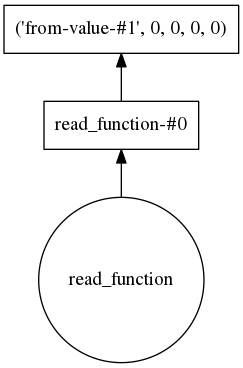

In [58]:
data.visualize()

In [64]:

data

tornado.application - ERROR - Future <tornado.concurrent.Future object at 0x2aaae203bba8> exception was never retrieved: Traceback (most recent call last):
  File "/nobackup/rpaberna/conda/envs/pangeo/lib/python3.6/site-packages/tornado/gen.py", line 1069, in run
    yielded = self.gen.send(value)
  File "/nobackup/rpaberna/conda/envs/pangeo/lib/python3.6/site-packages/distributed/client.py", line 1316, in wait
    raise AllExit()
distributed.client.AllExit
tornado.application - ERROR - Future <tornado.concurrent.Future object at 0x2aaae203b320> exception was never retrieved: Traceback (most recent call last):
  File "/nobackup/rpaberna/conda/envs/pangeo/lib/python3.6/site-packages/tornado/gen.py", line 1069, in run
    yielded = self.gen.send(value)
  File "/nobackup/rpaberna/conda/envs/pangeo/lib/python3.6/site-packages/distributed/client.py", line 1316, in wait
    raise AllExit()
distributed.client.AllExit
tornado.application - ERROR - Future <tornado.concurrent.Future object at 0x

dask.array<concatenate, shape=(9029, 13, 4320, 4320), dtype=float32, chunksize=(1, 13, 4320, 4320)>

In [67]:
data.mean().compute()

distributed.utils - ERROR - ('mean_agg-aggregate-9065339bcb8b5ed1bcc4de5da119d59c',)
Traceback (most recent call last):
  File "/nobackup/rpaberna/conda/envs/pangeo/lib/python3.6/site-packages/distributed/client.py", line 1334, in _gather
    st = self.futures[key]
KeyError: "('mean_agg-aggregate-9065339bcb8b5ed1bcc4de5da119d59c',)"

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/nobackup/rpaberna/conda/envs/pangeo/lib/python3.6/site-packages/distributed/utils.py", line 237, in f
    result[0] = yield make_coro()
  File "/nobackup/rpaberna/conda/envs/pangeo/lib/python3.6/site-packages/tornado/gen.py", line 1055, in run
    value = future.result()
  File "/nobackup/rpaberna/conda/envs/pangeo/lib/python3.6/site-packages/tornado/concurrent.py", line 238, in result
    raise_exc_info(self._exc_info)
  File "<string>", line 4, in raise_exc_info
  File "/nobackup/rpaberna/conda/envs/pangeo/lib/python3.6/site-packages/tornado/g

KeyboardInterrupt: 

In [22]:
import multiprocessing

In [23]:
multiprocessing.cpu_count()

40